# What makes a good In Flight Check in?

Zeegan George, Nick Steil, and Brandon Hawkins

CMN Hospitals is an organization that partners with corporate organizations such as Walmart, Target, or Panda Express to fundraise money for local hospitals. You may have been asked to donate money to such a cause while checking out at the store. Hospitals then can choose to partner with CMN Hospitals allowing them access to these donated funds. In attempt to increase donations, hospital employees will visit individual participating locations and meet with management. Some of these visits bring in an increase of donations while others do not.

Our project will build a machine learning model to predict whether a location is likely to increase donations by 50% as a result of a hospital employee visit. We will use data from a corporate organization and it's participating locations. Due to contract aggrements the corporate organization will remain nameless and we will refer to it as "Dunder Mifflin".

***Run this code in your anaconda command prompt before running this code: `conda install -c conda-forge imbalanced-learn `

*****NEW!* Use the `target_number` below to set your threshhold for being a positive observation. Remember that it is based on the % increase from the three prior days to the 3 days to come!

We will begin by determing our target variable. It is determined by calculating those locations that increased their donations by at least 50% for the 3 days after the visit, compared to the 3 days before the visit. Our data will have a 1 for all locations that did benefit from the visit and 0 for those that did not.

In [2]:
#determine locations that benefitted from visit
target_number = .5

We will now import the necessary packages to look at our data.

In [3]:
#import our basic data manipulation modules
import pandas as pd
import numpy as np
import scipy

#import our basic visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

#import modules that describe distributions
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

In [4]:
#define function for computing target
def target_value(df):
  if df['target%'] >= (target_number):
    return 1
  else:
    return 0

We will now import our data set and look at our first few observations.

In [5]:
#import dataset
df = pd.read_csv("Dunder Mifflin Fundraising.csv")
df.head()

,ID,Hour_of_Day,Days_since_last_Checkin,Check_Ins,Contacts Created,Images Uploaded,Notes Written,Checkin_w_images,Checkin_w_Contact,Checkin_w_Note,...,Running average,last week change from running,Percentile of Running,Percentile of Running by Market,Percentile of Past 1-3,Percentile of Past 1-3 by Market,Percentile of Past 3-6,Percentile of Past 3-6 by Market,Percentile of Past Week Change,Percentile of Past Week Change by market
0,182887-5-12-2017,12,4,1,2,2,1,1,1,1,...,565.909091,2.451673,0.875,0.772,0.962,1.000,0.613,0.058,0.998,1.000
1,182887-5-15-2017,12,3,1,0,0,1,0,0,1,...,821.000000,1.139261,0.904,0.673,0.914,0.687,0.962,1.000,0.087,0.000
2,182887-5-18-2017,11,3,1,0,0,1,0,0,1,...,886.882353,0.346665,0.912,0.776,0.908,0.705,0.913,0.705,0.211,0.588
3,182887-5-22-2017,12,4,1,0,1,0,1,0,0,...,910.952381,-0.142656,0.894,0.734,0.723,0.294,0.932,0.882,0.014,0.000
4,182887-5-30-2017,12,8,1,0,0,0,0,0,0,...,898.896552,-0.166015,0.890,0.600,0.854,0.352,0.857,0.529,0.194,0.294


At a general level our data looks good! Let's go ahead and take a deeper look.

In [6]:
#get info on data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 34 columns):
ID                                          2198 non-null object
Hour_of_Day                                 2198 non-null int64
Days_since_last_Checkin                     2198 non-null int64
Check_Ins                                   2198 non-null int64
Contacts Created                            2198 non-null int64
Images Uploaded                             2198 non-null int64
Notes Written                               2198 non-null int64
Checkin_w_images                            2198 non-null int64
Checkin_w_Contact                           2198 non-null int64
Checkin_w_Note                              2198 non-null int64
Checkin_w_I_C                               2198 non-null int64
Checkin_w_C_N                               2198 non-null int64
Checkin_w_I_N                               2198 non-null int64
Checkin_w_All                               2198 non-null in

In [6]:
#to get rid of new data uncomment the following
#df = df.drop(df[df['ID'].str[:2]="s"].index)

We will now define and drop a few variables that will give us better results for our model. We will create a variable that computes the percent increase of donations a location raises in the three days following a visit. We will also create our target variable and drop unneccessary features. 

We will also convert some of our data to categorical so that we can work with it.

In [7]:
#create percent increase variable
df['target%'] = ((df['Past 1-3 avg']-df['Future 0-3 avg'])/df['Future 0-3 avg'])
#create target variable
df['target'] = df.apply(target_value, axis=1)

#testing to see if we can use normalized variables only- would allow it to generalize over other corporate partners potentially
df = df.drop(['Campaign Day Funds','day of month','target%','Future 0-3 avg','Past 1-3 avg','Past 3-6 avg','Running average','FundraisingYear'],axis=1)
#df = df.drop(['Campaign Day Funds','day of month','target%','Future 0-3 avg'],axis=1)
#df[['Hour_of_Day','FundraisingYear','day of week']] = df[['Hour_of_Day','FundraisingYear','day of week']].astype('category')
df[['Hour_of_Day','day of week']] = df[['Hour_of_Day','day of week']].astype('category')

Now that we have taken care of that, we will create dummy variables for some of our data to help in modelling.

In [8]:
#create dummy variables
df = pd.get_dummies(data=df,
                    columns=['Hour_of_Day','day of week'])
                    #columns=['Hour','Property Type','PopulationRank','LocRegion','FundraisingYear','day of week'])

We now want to look at how our variables correlate with each other and our target variable. This will give us a general idea about what features might have the most impact on increses in donations.

In [10]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()

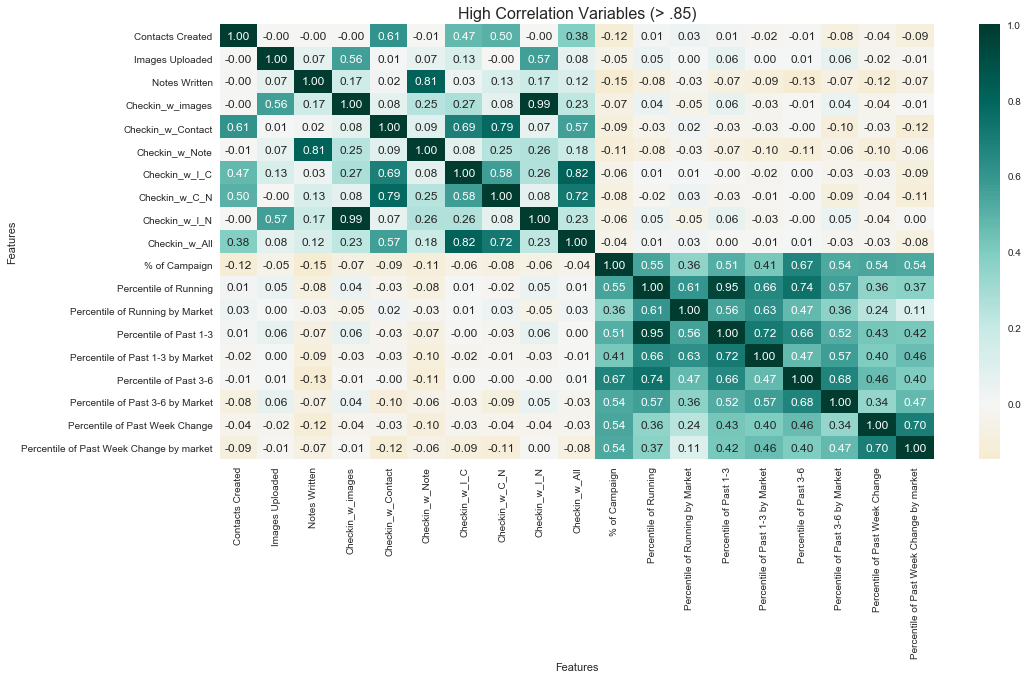

In [13]:
#Throw out any variables that don't have at least .7 correlation with something else or isn't Target
selected_feats=aux[(aux>0.50)| ((aux>0.215207) & (aux<0.215209))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables (> .85)',fontsize=16)
plt.xlabel('Features')
plt.ylabel('Features')
#show the plot
plt.show()


This heat map helps us to know how different variables correlate with each other. Let's go ahead and see how our variables correlate with our target.

In [11]:
#list of most correlated variables with target
correlation = df.corr()
correlation = correlation['target'].sort_values(ascending=False)
correlation

target                                      1.000000
last week change from running               0.440929
Change in past week                         0.176291
Checkin_w_I_N                               0.096354
Checkin_w_images                            0.096341
day of week_7                               0.079715
Images Uploaded                             0.073846
Hour_of_Day_13                              0.069507
day of week_6                               0.067182
Percentile of Past 1-3                      0.042811
Hour_of_Day_1                               0.030694
Hour_of_Day_23                              0.030694
Hour_of_Day_14                              0.024753
day of week_1                               0.018493
Contacts Created                            0.018399
day of week_2                               0.016779
Checkin_w_I_C                               0.013754
Hour_of_Day_11                              0.007097
Hour_of_Day_8                               0.

This helps us to see how our features correlate with our target. We can see that our top three correlated variables with the target are last week change in donations from current donations, the change in the past week of donations, and whether a hospital employee documented images in their visit.

In [12]:
#df = df.drop(['Checkin_w_I_N','LocRegion_BC','LocRegion_CWI','LocRegion_Regional','FundraisingYear_2017','Week'],axis=1)
df = df.drop(['Checkin_w_I_N'],axis=1)

Now let's go ahead and look at our summary statistics to make sure everything looks good.

In [14]:
#look at summary statistics
df.describe()

,Days_since_last_Checkin,Check_Ins,Contacts Created,Images Uploaded,Notes Written,Checkin_w_images,Checkin_w_Contact,Checkin_w_Note,Checkin_w_I_C,Checkin_w_C_N,...,Hour_of_Day_21,Hour_of_Day_22,Hour_of_Day_23,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6,day of week_7
count,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,...,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000
mean,17.782985,0.954959,0.143767,1.581893,0.570974,0.405369,0.092357,0.527753,0.044586,0.058235,...,0.004095,0.003640,0.000455,0.027753,0.142402,0.204277,0.208826,0.189718,0.152411,0.074613
std,12.130970,0.309566,0.478281,2.858104,0.549932,0.521638,0.298876,0.530288,0.217185,0.243762,...,0.063873,0.060234,0.021330,0.164300,0.349542,0.403264,0.406562,0.392167,0.359501,0.262826
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,3.000000,7.000000,39.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It looks good so we can now move on to our modeling.

## Modeling

We'll begin by importing our necessary packages to prepare our data and run our models.

In [17]:
#Import the models we will be using
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

#Bring in our crossvalidations
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold, StratifiedShuffleSplit

#Import the modules we will use to score our models
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, accuracy_score, mean_squared_error, log_loss, roc_auc_score, average_precision_score, precision_score
import itertools
from imblearn.over_sampling import SMOTENC,SMOTE,ADASYN
from collections import Counter

We will now prepare our data set to split for training and testing. Then we will split it into a training data set and test data set.

In [18]:
#Retain our id fields
Id = df['ID']
#Create the two new data frames
train_y = pd.DataFrame()
train_x = pd.DataFrame()
#save our Target as our y variable
train_y['target'] = df['target']
train_x = df.drop(['target','ID'],axis=1)

In [19]:
#perform the train & test split
X1_train, X_test, y1_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=10, stratify=train_y)

### *Oversampling through synthetic observation creation*

In [20]:
print(X1_train.shape)
print(y1_train.shape)

(1758, 52)
(1758, 1)


In [21]:
sm = ADASYN(random_state=42,n_jobs=-1)
res_x, res_y = sm.fit_resample(X1_train, y1_train)
y_train = pd.DataFrame(res_y)
X_train = pd.DataFrame(res_x)

In [22]:
print('New dataset shape %s' % Counter(res_y))
labels = np.unique(y_train)
print(labels)

New dataset shape Counter({1: 1202, 0: 1185})
[0 1]


In [23]:
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [24]:
F1_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
tpr = make_scorer(average_precision_score)
pre = make_scorer(precision_score)
scoring = pre

In [25]:
#Create a variable that will show us the best parameters, with what accuracy it predicts and what the F1 score is for its predictions
def show_me_the_money(model,test_y,test_x,train_y=y_train,train_x=X_train):
    #print("Best Params: {}".format(model.best_params_))
    print('Scoring Metrics')
    train_predictions = model.predict(train_x)
    test_predictions = model.predict(test_x)
    print('*******************************************************')
    print(scoring)
    print("Train Accuracy: {}".format(accuracy_score(y_train, train_predictions)))
    print("Test Accuracy: {}".format(accuracy_score(y_test, test_predictions)))

    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    
    train_auc = roc_auc_score(y_train, train_predictions)
    test_auc = roc_auc_score(y_test, test_predictions)
    
    train_tpr = roc_auc_score(y_train, train_predictions)
    test_tpr = roc_auc_score(y_test, test_predictions)
    
    train_pre = precision_score(y_train, train_predictions)
    test_pre = precision_score(y_test, test_predictions)
    
    print('*******************************************************')
    print("Train MSE: {}".format(train_mse))
    print("Test MSE: {}".format(test_mse))
    print('*******************************************************')
    print("Train ROC AUC: {}".format(train_auc))
    print("Test ROC AUC: {}".format(test_auc))
    print('*******************************************************')
    print("Train F1 Score: {}".format(f1_score(y_train, train_predictions,average='macro')))
    print("Test F1 Score: {}".format(f1_score(test_y, model.predict(test_x),average='macro')))
    print('*******************************************************')
    print("Train ROC AUC: {}".format(train_tpr))
    print("Test ROC AUC: {}".format(test_tpr))
    print('*******************************************************')
    print("Train Precision: {}".format(train_pre))
    print("Test Precision: {}".format(test_pre))
    print('*******************************************************')
    

In [26]:
#generalized confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted label', size = 16)

    
#specific matrix for our needs    
def show_con_matrix(model,test_y,test_x,title):
    pred_matrix = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(pred_matrix, classes = ['Less effective', 'More effective'],
                      title = title)
    plt.show

In [27]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring,shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Linear Support Vector Classification

In [25]:
#set up model, allow it to use all cores
Lsvc = svm.LinearSVC(class_weight='balanced',dual=False,random_state=83)

#set hyperparameters
param_dist = {"C": [.25,.05,1,1.5,2],
             "tol":[.00001,.0001,.001,.01,.1],
             "penalty":['l1','l2'],
             "loss":['hinge','squared_hinge']}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
Lsvc_randsearch = RandomizedSearchCV(Lsvc,param_distributions=param_dist,scoring=scoring,cv=5,n_iter=250,error_score=0)

#fit model
Lsvc_randsearch.fit(X_train,y_train)

#save model
optimised_Lsvc = Lsvc_randsearch.best_estimator_
optimised_Lsvc

LinearSVC(C=0.05, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=83, tol=0.01, verbose=0)

In [26]:
#see how it did
show_me_the_money(optimised_Lsvc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.817001675041876
Test Accuracy: 0.8363636363636363
*******************************************************
Train MSE: 0.18299832495812396
Test MSE: 0.16363636363636364
*******************************************************
Train ROC AUC: 0.8173984869051001
Test ROC AUC: 0.8225848225848227
*******************************************************
Train F1 Score: 0.8166054300508083
Test F1 Score: 0.8167345427619399
*******************************************************
Train ROC AUC: 0.8173984869051001
Test ROC AUC: 0.8225848225848227
*******************************************************
Train Precision: 0.8566108007448789
Test Precision: 0.7320261437908496
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

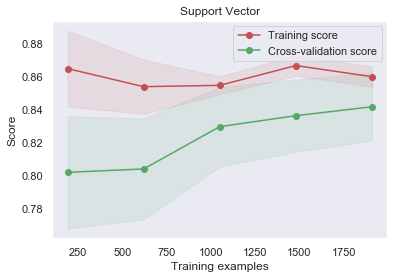

In [27]:
plot_learning_curve(optimised_Lsvc,'Linear Support Vector',X=X_train,y=y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


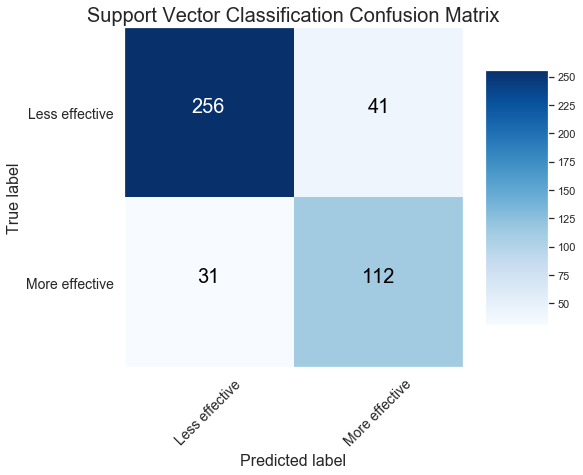

In [28]:
#Show confusion matrix
show_con_matrix(optimised_Lsvc,y_test, X_test,'Support Vector Classification Confusion Matrix')

### K-Nearest Neighbors

In [29]:
#set up model, allow it to use all cores
knk = KNeighborsClassifier(n_jobs = -1)

#set hyperparameters
param_grid = {"n_neighbors": [3,4,5,6,7],
             "weights": ['uniform','distance'],
              "p": [1,2,3]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
knk_gridsearch = GridSearchCV(knk,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
knk_gridsearch.fit(X_train,y_train)

#save model
optimised_knk = knk_gridsearch.best_estimator_
optimised_knk

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

In [30]:
#see how it did
show_me_the_money(optimised_knk,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9250418760469011
Test Accuracy: 0.8136363636363636
*******************************************************
Train MSE: 0.07495812395309882
Test MSE: 0.18636363636363637
*******************************************************
Train ROC AUC: 0.9253943201069057
Test ROC AUC: 0.754985754985755
*******************************************************
Train F1 Score: 0.9249230572515873
Test F1 Score: 0.770920634920635
*******************************************************
Train ROC AUC: 0.9253943201069057
Test ROC AUC: 0.754985754985755
*******************************************************
Train Precision: 0.9697247706422019
Test Precision: 0.7850467289719626
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

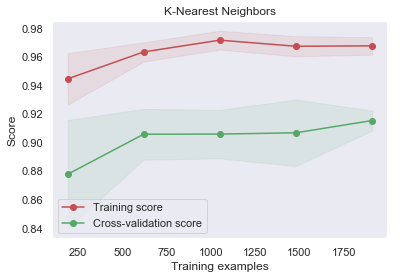

In [31]:
#High is Better
plot_learning_curve(optimised_knk,'K-Nearest Neighbors',X_train,y_train,cv=5,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


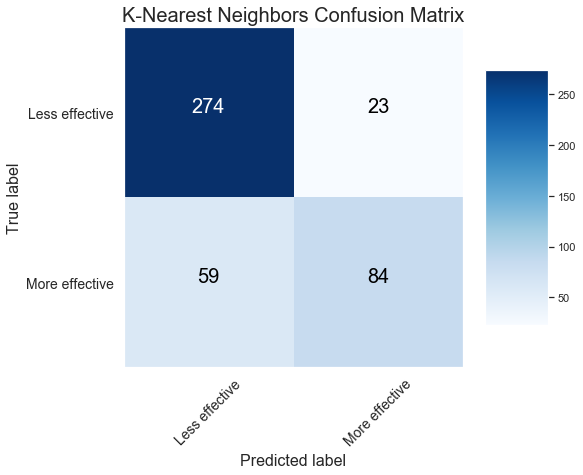

In [32]:
#Show confusion matrix
show_con_matrix(optimised_knk,y_test, X_test,'K-Nearest Neighbors Confusion Matrix')

## Support Vector Classification

In [33]:
#set up model, allow it to use all cores
svc = svm.SVC(class_weight='balanced')

#set hyperparameters
param_grid = {"C": [.25,.05,1,1.5,2,2.5,3,3.5],
             "tol":[.00001,.0001,.001,.005,.01,.05,.1],
             "kernel":['poly', 'rbf', 'sigmoid']}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
svc_gridsearch = GridSearchCV(svc,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
svc_gridsearch.fit(X_train,y_train)

#save model
optimised_svc = svc_gridsearch.best_estimator_
optimised_svc

SVC(C=3, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=1e-05, verbose=False)

In [34]:
#see how it did
show_me_the_money(optimised_svc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9505862646566164
Test Accuracy: 0.8681818181818182
*******************************************************
Train MSE: 0.049413735343383586
Test MSE: 0.1318181818181818
*******************************************************
Train ROC AUC: 0.9506907835895494
Test ROC AUC: 0.8370888370888372
*******************************************************
Train F1 Score: 0.9505840462635349
Test F1 Score: 0.8456849845201239
*******************************************************
Train ROC AUC: 0.9506907835895494
Test ROC AUC: 0.8370888370888372
*******************************************************
Train Precision: 0.9640718562874252
Test Precision: 0.8294573643410853
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

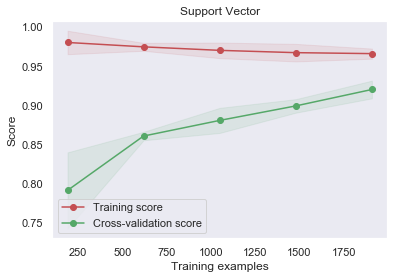

In [35]:
plot_learning_curve(optimised_svc,'Support Vector',X=X_train,y=y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


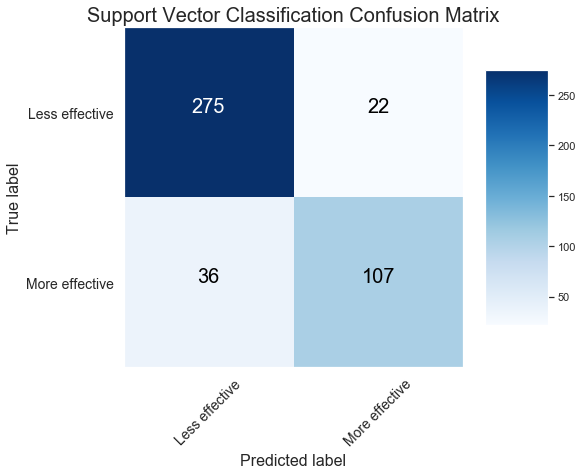

In [36]:
#Show confusion matrix
show_con_matrix(optimised_svc,y_test, X_test,'Support Vector Classification Confusion Matrix')

### Random Forrest Classifiers

In [28]:
#set up model, allow it to use all cores
rfc = RandomForestClassifier(random_state=42, n_jobs = -1)

#set hyperparameters
dist_grid = {"n_estimators": [ 105, 110, 115, 120, 150, 200, 250],
             "min_samples_leaf":[2,3,4],
             "class_weight":["balanced", "balanced_subsample"],
             "oob_score":[True,False],
             "bootstrap":[True,False]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
rfc_randsearch = RandomizedSearchCV(rfc,dist_grid,scoring=scoring,cv=5,n_jobs=-1,n_iter=250,error_score=0)

#fit model
rfc_randsearch.fit(X_train,y_train)

#save model
optimised_rfc = rfc_randsearch.best_estimator_
optimised_rfc

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=110, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [29]:
#see how it did
show_me_the_money(optimised_rfc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9945538332635107
Test Accuracy: 0.9204545454545454
*******************************************************
Train MSE: 0.005446166736489317
Test MSE: 0.07954545454545454
*******************************************************
Train ROC AUC: 0.9945505732358868
Test ROC AUC: 0.8921263921263921
*******************************************************
Train F1 Score: 0.9945535235531014
Test F1 Score: 0.9059088048585271
*******************************************************
Train ROC AUC: 0.9945505732358868
Test ROC AUC: 0.8921263921263921
*******************************************************
Train Precision: 0.9941812136325852
Test Precision: 0.9354838709677419
*******************************************************


<module 'matplotlib.pyplot' from '/Users/brandonhawkins/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

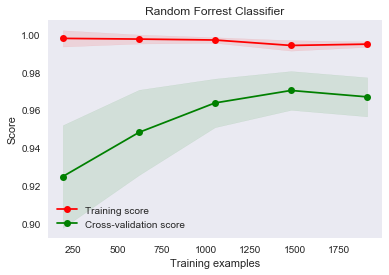

In [30]:
#High is Better
plot_learning_curve(optimised_rfc,'Random Forrest Classifier',X_train,y_train,cv=5,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


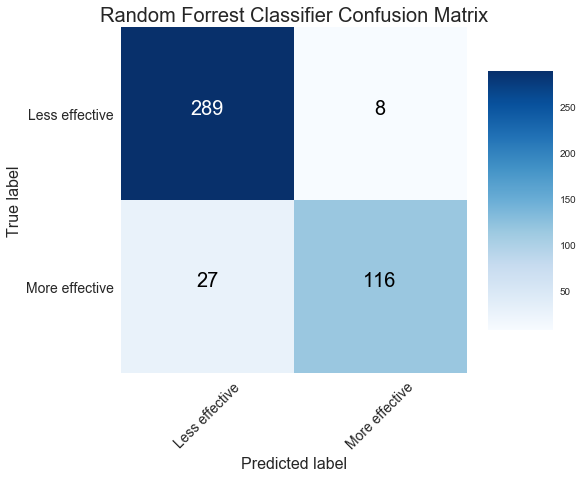

In [31]:
#Show confusion matrix
show_con_matrix(optimised_rfc,y_test, X_test,'Random Forrest Classifier Confusion Matrix')

Text(0.5,1,'Feature Importances')

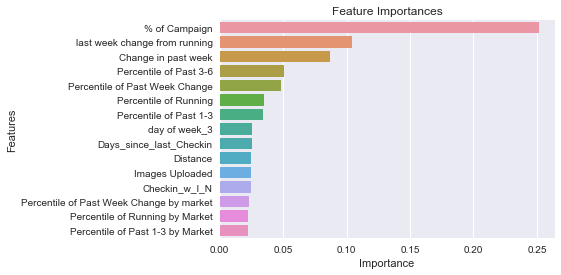

In [32]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_rfc = sorted(list(zip(train_x.columns, optimised_rfc.feature_importances_)), key=lambda x: x[1], reverse=True)
#Create a plot of the top ten importances
importance_rfc = pd.DataFrame(imp_feat_rfc,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_rfc.head(15))
plt.title('Feature Importances')

## SKLearn Gradient Boost
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [42]:
#set up model, allow it to use all cores
gbc = GradientBoostingClassifier()

#set hyperparameters
param_grid = {"learning_rate": [.0001,.001,.01,.03,.05,.07,.9],
             "n_estimators": [50,100,125,150,175,200],
             "max_depth":[2,3,4,5,6]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
gbc_gridsearch = GridSearchCV(gbc,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
gbc_gridsearch.fit(X_train,y_train)

#save model
optimised_gbc = gbc_gridsearch.best_estimator_
optimised_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.07, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=175,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [43]:
#see how it did
show_me_the_money(optimised_gbc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9660804020100503
Test Accuracy: 0.9
*******************************************************
Train MSE: 0.03391959798994975
Test MSE: 0.1
*******************************************************
Train ROC AUC: 0.9662331512989678
Test ROC AUC: 0.8824138824138824
*******************************************************
Train F1 Score: 0.9660746848726047
Test F1 Score: 0.885196517943974
*******************************************************
Train ROC AUC: 0.9662331512989678
Test ROC AUC: 0.8824138824138824
*******************************************************
Train Precision: 0.9861351819757366
Test Precision: 0.8561151079136691
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

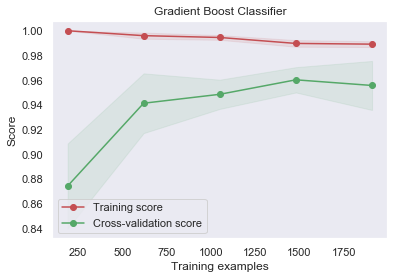

In [44]:
#High is Better
plot_learning_curve(optimised_gbc,'Gradient Boost Classifier',X_train,y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


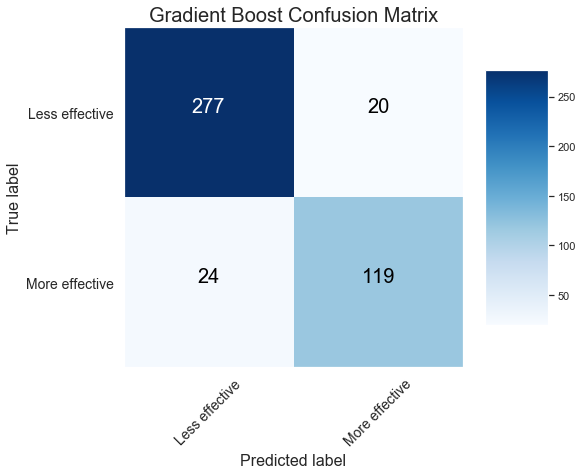

In [45]:
#Show confusion matrix
show_con_matrix(optimised_gbc,y_test, X_test,'Gradient Boost Confusion Matrix')

Text(0.5, 1.0, 'Feature Importances')

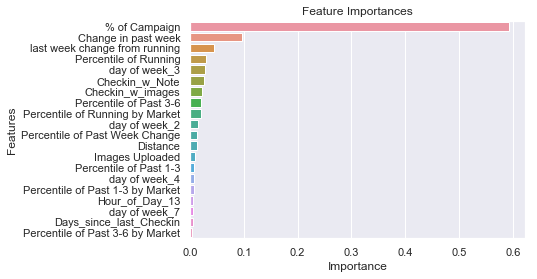

In [46]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_gbc = sorted(list(zip(train_x.columns, optimised_gbc.feature_importances_)), key=lambda x: x[1], reverse=True)
#Create a plot of the top ten importances
importance_gbc = pd.DataFrame(imp_feat_gbc,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_gbc.head(20))
plt.title('Feature Importances')

## XGBoost

In [47]:
#X_test_xgb = X_test.as_matrix()
#X_train_xgb = X_train.as_matrix()

#set up model, allow it to use all cores
xgb = XGBClassifier(n_jobs=-1)

#set hyperparameters
param_dist = { 'max_depth':range(3,10),
             'min_child_weight':range(6,12),
             "n_estimators":range(100,400,5),
             "learning_rate":[.0000001,.000001,.00001,.0001,.001,.005,.01,.05,.1]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
xgb_gridsearch = RandomizedSearchCV(xgb,param_distributions=param_dist,scoring=scoring,cv=5,n_iter=250,error_score=0,n_jobs=-1)

#fit model
xgb_gridsearch.fit(X_train,y_train)

#save model
optimised_xgb = xgb_gridsearch.best_estimator_
optimised_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=9, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [48]:
#see how it did
show_me_the_money(optimised_xgb,test_y=y_test,test_x=X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9434673366834171
Test Accuracy: 0.8909090909090909
*******************************************************
Train MSE: 0.056532663316582916
Test MSE: 0.10909090909090909
*******************************************************
Train ROC AUC: 0.9436945610656902
Test ROC AUC: 0.8629888629888631
*******************************************************
Train F1 Score: 0.943437332167855
Test F1 Score: 0.8722910216718267
*******************************************************
Train ROC AUC: 0.9436945610656902
Test ROC AUC: 0.8629888629888631
*******************************************************
Train Precision: 0.9725663716814159
Test Precision: 0.8682170542635659
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

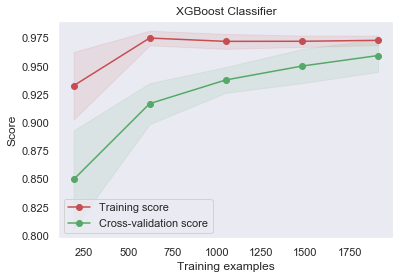

In [49]:
#High is Better
plot_learning_curve(optimised_xgb,'XGBoost Classifier',X_train,y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


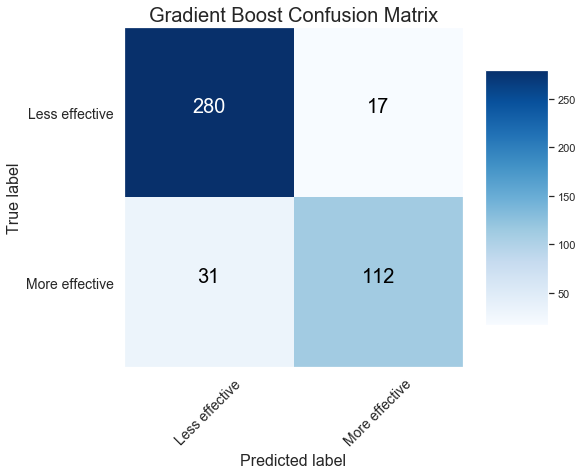

In [50]:
#Show confusion matrix
show_con_matrix(optimised_xgb,y_test, X_test,'Gradient Boost Confusion Matrix')

Text(0.5, 1.0, 'Feature Importances')

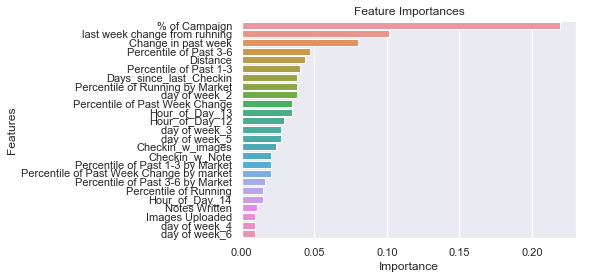

In [51]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_xgb = sorted(list(zip(train_x.columns, optimised_xgb.feature_importances_)), key=lambda x: x[1], reverse=True)
#Create a plot of the top ten importances
importance_xgb = pd.DataFrame(imp_feat_xgb,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_xgb.head(25))
plt.title('Feature Importances')

In [52]:
#optimised_xgb.predict_proba(X_test)

In [38]:
#create predictions for random forest
predictions = optimised_rfc.predict_proba(X_test)
print(predictions)

[[7.80591130e-01 2.19408870e-01]
 [9.21677821e-01 7.83221786e-02]
 [9.63436512e-01 3.65634884e-02]
 [1.14527470e-02 9.88547253e-01]
 [1.83196393e-01 8.16803607e-01]
 [4.07824568e-02 9.59217543e-01]
 [9.47397707e-01 5.26022929e-02]
 [9.48395925e-01 5.16040745e-02]
 [1.22365876e-02 9.87763412e-01]
 [6.18066186e-01 3.81933814e-01]
 [9.64058667e-01 3.59413331e-02]
 [8.65025005e-01 1.34974995e-01]
 [8.17390580e-01 1.82609420e-01]
 [8.61508458e-01 1.38491542e-01]
 [9.03097220e-01 9.69027804e-02]
 [9.57524091e-01 4.24759094e-02]
 [8.41684039e-01 1.58315961e-01]
 [2.15588353e-02 9.78441165e-01]
 [9.60678739e-01 3.93212611e-02]
 [9.90520218e-01 9.47978207e-03]
 [6.45165998e-01 3.54834002e-01]
 [0.00000000e+00 1.00000000e+00]
 [8.20562929e-01 1.79437071e-01]
 [9.32064320e-01 6.79356802e-02]
 [2.32116954e-02 9.76788305e-01]
 [8.83206742e-01 1.16793258e-01]
 [8.16005583e-01 1.83994417e-01]
 [9.40932017e-01 5.90679831e-02]
 [6.97529616e-01 3.02470384e-01]
 [9.89409737e-01 1.05902626e-02]
 [7.571234